In [3]:
#OpenStreetMap (OSM) is a collaborative project to create a free and editable map of the world.
#Getting a road network from OSMnx is one of the core functionalities of the library
#Let’s get the street network for the University of Canterbury:
!pip install osmnx

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import the OSMnx library
import osmnx as ox
import matplotlib.pyplot as plt
# Make sure this magic command has been run in a cell near the top of your notebook
%matplotlib inline

# Define the location for which we want to retrieve OSM information
place = "University of Canterbury"
# Extract the street network graph based on the specified place name
network = ox.graph_from_place(place)

In [5]:
#It is also possible to extract the street network graph based on bounding box coordinates
#  Define the bouding box coordinates. These coordinates are in the epsg:4326
north = -43.5199121
south = -43.528178
east = 172.5883328
west = 172.5728817

# extract the street network graph based on UC bounding box coordinates
network = ox.graph_from_bbox((north, south, east, west), network_type='all')

In [6]:
#Check the type of the network variable:
type(network)

networkx.classes.multidigraph.MultiDiGraph

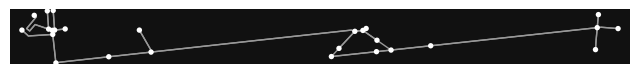

In [7]:
#networkx.classes.multidigraph.MultiDiGraph is a class provided by the NetworkX library, which is used for creating and manipulating directed graphs with multiple edges and self-loops.
# Plot the street network graph and get the figure and axis objects
fig, ax = ox.plot_graph(network)

In [8]:
#These are the nodes (intersections) and edges (street segments) within the UC bounding box. We can separate nodes and edges to create GeoDataFrames:
# Convert the graph's nodes and edges into GeoDataFrames
nodes, edges = ox.graph_to_gdfs(network)

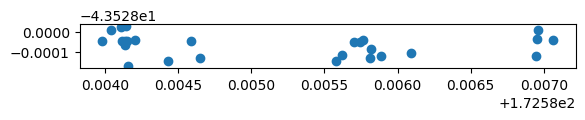

In [9]:
#Visualize road intersections:
nodes.plot()
plt.show()

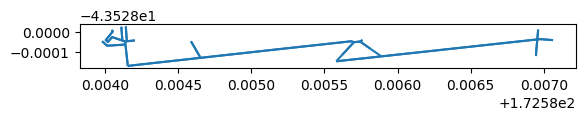

In [10]:
#Visualize road edges:
edges.plot()
plt.show()

In [11]:
#Geocoding is the process of converting a textual description of a location, such as a place name or address, into geographical coordinates (latitude and longitude) on the Earth’s surface.
#Let'sgeocode some addresses in Christchurch:
import geopandas as gpd
from shapely.geometry import Point
# List of addresses to geocode
address_list = [
    "11A Montana Avenue, Christchurch, New Zealand",
    "9 Zenith Place, Christchurch, New Zealand",
    "611 Cashel Street, Christchurch, New Zealand"
]
geom = []  # List to store Point geometries
# Loop through the address list and geocode each address
for address in address_list:
    geocode_result = ox.geocode(address)
    if geocode_result is not None: # Check if geocoding found a result
        y, x = geocode_result
        point = Point(x, y)  # Create a Point geometry
        geom.append(point)    # Add the Point to the list

# Create GeoDataFrame with a dictionary of attributes and a list of geometries
gdf = gpd.GeoDataFrame({'Address': address_list}, geometry=geom, crs=4326)

# Print the GeoDataFrame
print(gdf)

                                         Address                     geometry
0  11A Montana Avenue, Christchurch, New Zealand  POINT (172.58158 -43.52062)
1      9 Zenith Place, Christchurch, New Zealand  POINT (172.53609 -43.53042)
2   611 Cashel Street, Christchurch, New Zealand  POINT (172.66876 -43.53261)


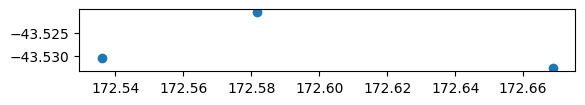

In [12]:
#Plot the result:
gdf.plot()
plt.show()

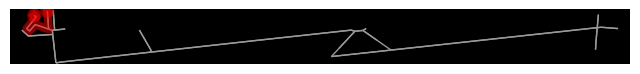

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
#Routing is the process of determining the optimal path or route between two or more locations in a network, such as a transportation or communication network.
#Let's try to find the shortest path between beatrice tinsley and campus security using Networkx Librabry:
import networkx as nx

# Define the start and end points for routing
start_point = (-43.522804, 172.583258)  # Latitude and longitude for BT
end_point = (-43.521537568382065, 172.57975565615905) # Latitude and longitude for security

# Find the nearest nodes to the start and end points
start_node = ox.distance.nearest_nodes(network, start_point[1], start_point[0])
end_node = ox.distance.nearest_nodes(network, end_point[1], end_point[0])
# Find the shortest path using networkx
route = nx.shortest_path(network, source=start_node, target=end_node, weight='length')

# Plot the route on the street network
ox.plot_graph_route(network, route, route_linewidth=6, node_size=0, bgcolor='k')

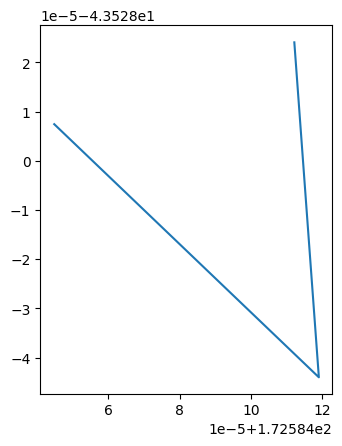

In [14]:
#We can transform the obtained route into a LineString and add it to a GeoDataFrame:
from shapely.geometry import LineString
# Convert the route to a list of (latitude, longitude) coordinates
route_coordinates = [(network.nodes[node]['x'],network.nodes[node]['y']) for node in route]
# Convert the list of coordinates into a LineString geometry
route_line = LineString(route_coordinates)
# Create a GeoDataFrame with the LineString geometry
route_gdf = gpd.GeoDataFrame({'geometry': [route_line]}, crs=4326)

# Inspect the result
route_gdf.plot()
plt.show()

In [15]:
#Extracting Area Boundaries:
#Let’s extract the polygon representing the UC boundaries:
# Geocode the place to a GeoDataFrame with the boundary
area = ox.geocode_to_gdf(place)
# Print the type of the 'area' variable
print(type(area))

<class 'geopandas.geodataframe.GeoDataFrame'>


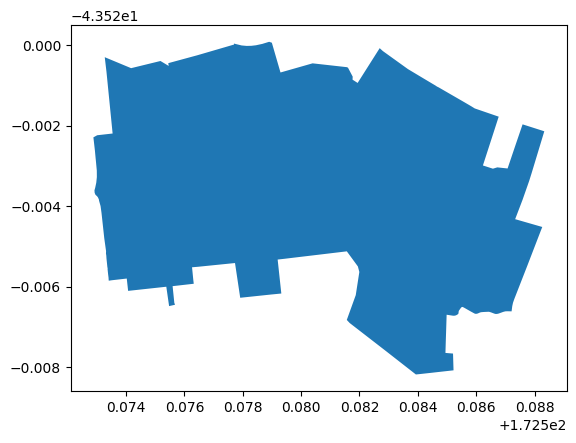

In [16]:
# Plot the polygon of the area
area.plot()
plt.show()

In [17]:
#Extracting geographic features by tags:
#In OpenStreetMap (OSM), tags are key-value pairs used to describe the characteristics and attributes of geographical features on the map.
#Each geographical feature, such as a road, building, or point of interest, can be tagged with one or more key-value pairs to provide additional information about that feature.
# Get building features for the specified place using the "building" tag
buildings = ox.features_from_place(place, tags={"building": True})

# Print the type of the 'buildings' variable
print(type(buildings))

<class 'geopandas.geodataframe.GeoDataFrame'>


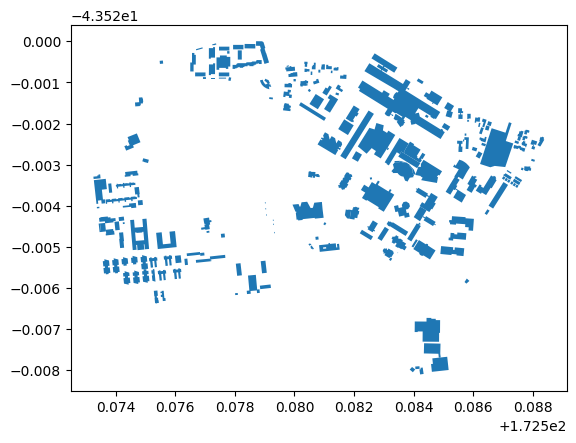

In [18]:
#Plot the buildings GeoDataFrame to visualize:
buildings.plot()
plt.show()

In [19]:
#Check the first two records in buildings:
buildings.head(2)

geometry  \
element  id                                                            
relation 13308076  POLYGON ((172.58432 -43.52522, 172.58431 -43.5...   
         13308526  POLYGON ((172.57367 -43.52472, 172.57366 -43.5...   

                  addr:city addr:country addr:postcode addr:street  \
element  id                                                          
relation 13308076       NaN          NaN           NaN         NaN   
         13308526       NaN          NaN           NaN         NaN   

                     building building:levels         name operator  \
element  id                                                           
relation 13308076  university             1;5     Meremere      NaN   
         13308526   dormitory             1;5  Nancy Simms      NaN   

                  addr:housenumber  ... shelter_type demolished:building  \
element  id                         ...                                    
relation 13308076              NaN  ...          NaN                 NaN   
         13308526              NaN  ...          NaN                 NaN   

                  construction          type building:min_level note  \
element  id                                                            
relation 13308076          NaN  multipolygon                NaN  NaN   
         13308526          NaN  multipolygon                NaN  NaN   

                  max_level min_level alt_name healthcare  
element  id                                                
relation 13308076       NaN       NaN      NaN        NaN  
         13308526       NaN       NaN      NaN        NaN  

[2 rows x 64 columns]

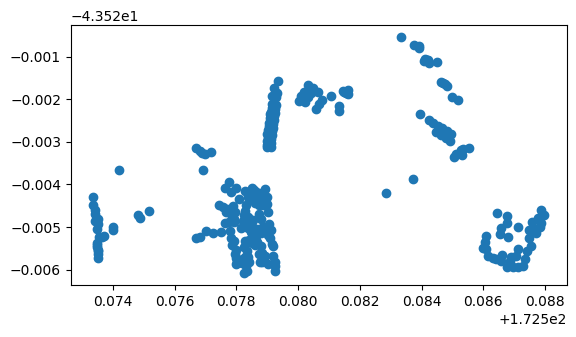

In [20]:
#Now, let’s retrieve all trees in the UC campus:
# Get tree features for the specified place using the "natural" tag with value "tree"
trees = ox.features_from_place(place, tags={"natural": "tree"})

# Plot the tree features
trees.plot()
plt.show()

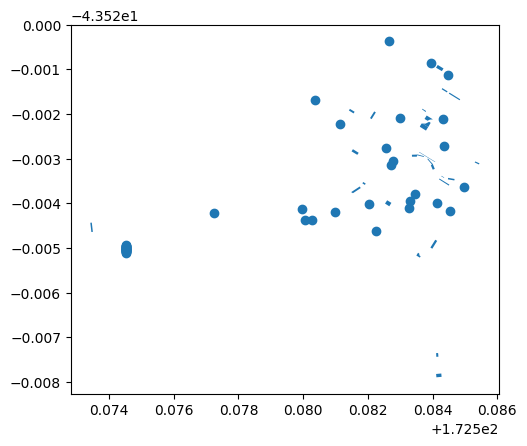

In [23]:
#Now, let’s retrieve all bicycle parkings in the UC campus:
#bicycleparking = ox.features_from_place(place, tags={"Transportation": "bicycle_parking"})
bicycleparking = ox.features_from_place(place, tags={"bicycle_parking":True})
# Plot the tree features
bicycleparking.plot()
plt.show()

In [24]:
#We can export OSM data to a shapefile or geopackage once we transform it in a GeoDataFrame.
#Let’s check the GeoDataFrames containing the UC buildings:
buildings.head(2)

geometry  \
element  id                                                            
relation 13308076  POLYGON ((172.58432 -43.52522, 172.58431 -43.5...   
         13308526  POLYGON ((172.57367 -43.52472, 172.57366 -43.5...   

                  addr:city addr:country addr:postcode addr:street  \
element  id                                                          
relation 13308076       NaN          NaN           NaN         NaN   
         13308526       NaN          NaN           NaN         NaN   

                     building building:levels         name operator  \
element  id                                                           
relation 13308076  university             1;5     Meremere      NaN   
         13308526   dormitory             1;5  Nancy Simms      NaN   

                  addr:housenumber  ... shelter_type demolished:building  \
element  id                         ...                                    
relation 13308076              NaN  ...          NaN                 NaN   
         13308526              NaN  ...          NaN                 NaN   

                  construction          type building:min_level note  \
element  id                                                            
relation 13308076          NaN  multipolygon                NaN  NaN   
         13308526          NaN  multipolygon                NaN  NaN   

                  max_level min_level alt_name healthcare  
element  id                                                
relation 13308076       NaN       NaN      NaN        NaN  
         13308526       NaN       NaN      NaN        NaN  

[2 rows x 64 columns]

In [25]:
#We can check all building types by applying pd.unique to the column building:
import pandas as pd
pd.unique(buildings.building)

array(['university', 'dormitory', 'yes', 'warehouse', 'retail', 'church',
       'industrial', 'house', 'service', 'shed', 'roof', 'no', 'detached',
       'semidetached_house', 'kindergarten', 'construction'], dtype=object)

In [26]:
buildings.columns

Index(['geometry', 'addr:city', 'addr:country', 'addr:postcode', 'addr:street',
       'building', 'building:levels', 'name', 'operator', 'addr:housenumber',
       'roof:levels', 'roof:shape', 'wikidata', 'description', 'image',
       'website', 'layer', 'nohousenumber', 'source',
       'building:levels:underground', 'addr:place', 'email', 'opening_hours',
       'payment:credit_cards', 'payment:debit_cards', 'phone', 'shop',
       'wheelchair', 'check_date', 'office', 'amenity', 'religion',
       'addr:suburb', 'ref:linz:address_id', 'heritage:website', 'historic',
       'start_date', 'club', 'internet_access', 'wikipedia', 'name:mi',
       'alt_name:en', 'access', 'bicycle_parking', 'capacity', 'building:part',
       'old_name', 'covered', 'fee', 'locked', 'operator:type',
       'place_of_worship', 'fax', 'ref:linz:building_id', 'shelter_type',
       'demolished:building', 'construction', 'type', 'building:min_level',
       'note', 'max_level', 'min_level', 'alt_name', 'he

In [27]:
# The number of rows indicates the number of buildings
# 194 in the UC area
buildings.shape

(208, 64)

In [28]:
#Select the geometry and names columns into a new GeoDataFrame:
buildings_sel=buildings[["geometry","name"]]
buildings_sel.head(2)

geometry  \
element  id                                                            
relation 13308076  POLYGON ((172.58432 -43.52522, 172.58431 -43.5...   
         13308526  POLYGON ((172.57367 -43.52472, 172.57366 -43.5...   

                          name  
element  id                     
relation 13308076     Meremere  
         13308526  Nancy Simms

In [29]:
#Export selection to a shapefile:
import os

# Create the directory if it does not exist
output_dir = "Lab4_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

buildings_sel.to_file("Lab4_data/buildings.shp")

In [30]:
#To finish in Pythonic style, let’s visualize in a single figure all the OSM data we downloaded:
import matplotlib.pyplot as plt

# Create a figure and an axis for plotting, and set the figure size
fig, eixo = plt.subplots(figsize=(10, 10))

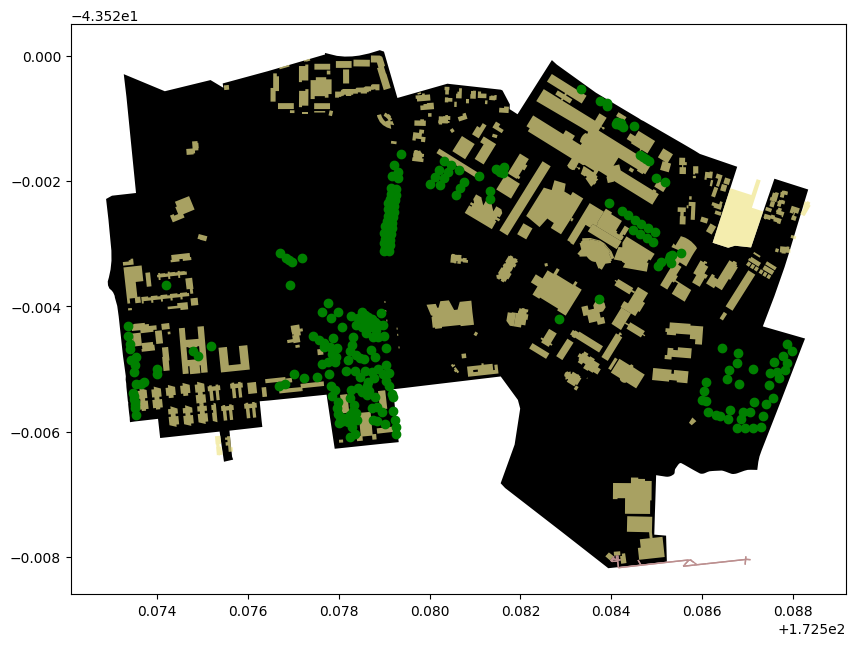

In [31]:
# Plot each of the GeoDataFrames on the plotting axis to ensure they are all on the same figure
# Plot the 'area' GeoDataFrame with black face color
area.plot(ax=eixo, facecolor="black")

# Plot the 'arestas' GeoDataFrame with specified line width and edge color
edges.plot(ax=eixo, linewidth=1, edgecolor="#BC8F8F")

# Plot the 'buildings' GeoDataFrame with khaki face color and adjusted transparency
buildings.plot(ax=eixo, facecolor="khaki", alpha=0.7)

# Plot the 'trees' GeoDataFrame with green face color
trees.plot(ax=eixo, facecolor="green")
plt.show()

In [ ]:
##Christchurch City Council Spatial Open Data Portal API:
#Most territorial authorities in New Zealand offer public access to their datasets such as council assets, infrastructure, planning rules, natural and cultural heritage. 
#The requests library is a popular Python library used for making HTTP requests to interact with web services and APIs. 
#The requests library is widely used in web scraping, API integration, and other web-related programming tasks.

In [32]:
#As an example, let’s pull the Christchurch manhole data from the Ch Council API using the requests library:
import requests
import json
import geopandas as gpd
# Define the API endpoint URL
endpoint = 'https://gis.ccc.govt.nz/server/rest/services/OpenData/StormWater/FeatureServer/16/query?outFields=*&where=1%3D1&f=geojson'
# Send a GET request to the API endpoint and retrieve the JSON response
response = requests.get(endpoint)

# Parse the JSON response into a dictionary
data = response.json()

In [33]:
# Extract the GeoJSON features from the dictionary
geojson_data = data['features']

# Create a GeoDataFrame from the GeoJSON features with the specified CRS
gdf = gpd.GeoDataFrame.from_features(geojson_data, crs=4326)  # WGS84

# Inspect the result
gdf.head(5)

,geometry,SwStructureID,Type,ServiceStatus,Ownership,Responsibility,Maintenance,LocationCertainty,InstallationCompany,Construction,...,CommissionDate,DecommissionDate,Comment,Project,ContractorExternalReference,SAPInternalReference,CreateDate,LastEditDate,Shape__Area,Shape__Length
0,"POLYGON ((172.71018 -43.48229, 172.71018 -43.4...",2,Manhole,In Service,CCC,Land Drainage Operations,Land Drainage Operations,Accurate,None,None,...,NaN,NaN,None,None,None,IE000000000010307748,NaN,1363917352000,4.841305,8.801498
1,"POLYGON ((172.71176 -43.48227, 172.71176 -43.4...",3,Manhole,In Service,CCC,Land Drainage Operations,Land Drainage Operations,Accurate,None,None,...,NaN,NaN,None,None,None,IE000000000010308026,NaN,1590707953000,6.535316,9.890124
2,"POLYGON ((172.7117 -43.48146, 172.7117 -43.481...",4,Manhole,In Service,CCC,Land Drainage Operations,Land Drainage Operations,Accurate,None,None,...,NaN,NaN,None,None,None,IE000000000010308296,NaN,1590707953000,2.321603,6.133053
3,"POLYGON ((172.71252 -43.48226, 172.71252 -43.4...",5,Manhole,In Service,CCC,Land Drainage Operations,Land Drainage Operations,Accurate,None,None,...,NaN,NaN,None,None,None,IE000000000010308555,NaN,1590707953000,3.031829,7.086492
4,"POLYGON ((172.71406 -43.48183, 172.71407 -43.4...",7,Manhole,In Service,CCC,Land Drainage Operations,Land Drainage Operations,Accurate,None,None,...,NaN,NaN,None,None,None,IE000000000010309080,NaN,1590707953000,4.573913,8.556871


In [34]:
gdf.to_file('Lab4_data/ccc_sw.gpkg')